In [1]:

import pandas as pd
import numpy as np
import yfinance as yf
import pandas_ta as ta

from stable_baselines3 import A2C, PPO
from stable_baselines3.common.vec_env import DummyVecEnv

from envs.Env_2 import Mult_asset_env
import matplotlib.pyplot as plt


2025-08-12 19:00:15.838132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755021617.562677   78270 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755021617.835815   78270 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-12 19:00:20.435239: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
assets = ['NVDA', 'AAPL', 'AMZN', 'JPM', 'IBM', 'MSFT', 'TSLA', 'GOOGL', 'META', 'HSBC']
start_date = '2019-01-01'
end_date = '2025-01-01'

In [3]:
# for symbol in assets:
#     df = yf.download(tickers = assets,
#                     start = start_date,
#                     end = end_date,
#                     interval = '1d',
#                     auto_adjust=True)
#     sta = df.stack()
#     df_flt = sta.reset_index()
#     df_flt.to_csv(f'/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/{symbol}_daily.CSV')

In [4]:
address1 = "/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/AAPL_daily.CSV"

apple_df = pd.read_csv(address1,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

address2 = "/home/micheal/Documents/Python_Library/RL_Optimization_Portfolio/data/raw/MSFT_daily.CSV"

MSFT_df = pd.read_csv(address2,
                  parse_dates=['Date'],
                  index_col='Date',
                  engine='pyarrow',
                  dtype_backend='pyarrow'
                  )

apple_df['Ticker'] = 'AAPL'
MSFT_df['Ticker'] = 'MSFT'
df = pd.concat([apple_df, MSFT_df], axis=0) 

In [5]:
df

,,Ticker,Close,High,Low,Open,Volume
Date,,,,,,,
2019-01-02,0,AAPL,37.617844,37.839379,36.738855,36.896073,148158800
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200
...,...,...,...,...,...,...,...
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200
2024-12-27,1507,MSFT,428.881104,433.553144,424.71712,432.935523,18117700


In [6]:
# Calculate the percentage daily difference for tomorrow

df['Ch_tomorrow'] = (df.groupby('Ticker')['Close']).pct_change(-1) * 100
df = df.dropna().copy()


In [7]:
df.isna().sum()

               0
Ticker         0
Close          0
High           0
Low            0
Open           0
Volume         0
Ch_tomorrow    0
dtype: int64

In [8]:
# Stock sign

df['Ch_direction'] = np.where(df.Ch_tomorrow > 0, 'UP', 'DOWN')

In [9]:
df['Log_return'] = (
    df.groupby('Ticker')['Close']
    .transform(lambda x: np.log(x / x.shift(1)))
)

In [10]:
df = df.dropna()

df.isna().sum()

                0
Ticker          0
Close           0
High            0
Low             0
Open            0
Volume          0
Ch_tomorrow     0
Ch_direction    0
Log_return      0
dtype: int64

In [11]:
df['Log_return_Z'] = (
    df.groupby('Ticker')['Close']
    .transform(lambda x: (x - x.mean()) / x.std())
)

In [12]:
df

,,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction,Log_return,Log_return_Z
Date,,,,,,,,,,,
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN,-0.104924,-1.871672
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP,0.041803,-1.8449
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN,-0.002228,-1.846355
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN,0.018884,-1.833917
2019-01-09,5,AAPL,36.519714,36.810329,35.64311,36.038533,180396400,-0.318606,DOWN,0.016839,-1.822626
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,1504,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN,-0.003097,1.790261
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP,0.009330,1.83231
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP,-0.002781,1.819737


In [13]:
def shrinking_ings (x):
    mapping = {}
    for col in x.dtypes [x.dtypes == 'int64[pyarrow]'].index:
        max_ = x[col].max()
        min_ = x[col].min()
        if min_ < 0:
            continue
        elif max_ < 255:
            mapping[col] = 'uint8[pyarrow]'
        elif max_ < 65_535:
            mapping[col] = 'uint16[pyarrow]'
        elif max_ < 4294967295:
            mapping[col] = 'uint32[pyarrow]'
    return x.astype(mapping)

df = shrinking_ings(df)

In [14]:
df

,,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction,Log_return,Log_return_Z
Date,,,,,,,,,,,
2019-01-03,1,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN,-0.104924,-1.871672
2019-01-04,2,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP,0.041803,-1.8449
2019-01-07,3,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN,-0.002228,-1.846355
2019-01-08,4,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN,0.018884,-1.833917
2019-01-09,5,AAPL,36.519714,36.810329,35.64311,36.038533,180396400,-0.318606,DOWN,0.016839,-1.822626
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,1504,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN,-0.003097,1.790261
2024-12-24,1505,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP,0.009330,1.83231
2024-12-26,1506,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP,-0.002781,1.819737


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3016 entries, 2019-01-03 to 2024-12-30
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0                 3016 non-null   uint16[pyarrow]
 1   Ticker        3016 non-null   object         
 2   Close         3016 non-null   double[pyarrow]
 3   High          3016 non-null   double[pyarrow]
 4   Low           3016 non-null   double[pyarrow]
 5   Open          3016 non-null   double[pyarrow]
 6   Volume        3016 non-null   uint32[pyarrow]
 7   Ch_tomorrow   3016 non-null   double[pyarrow]
 8   Ch_direction  3016 non-null   object         
 9   Log_return    3016 non-null   float64        
 10  Log_return_Z  3016 non-null   double[pyarrow]
dtypes: double[pyarrow](6), float64(1), object(2), uint16[pyarrow](1), uint32[pyarrow](1)
memory usage: 244.8+ KB


In [16]:
# Features

def recommended_features(data):
    
    
        
    if isinstance(data.index, pd.MultiIndex):
        data = data.reset_index()
        
    if '' in data.columns:
        data = data.drop(columns=[''])
        
        
    #MA
    data['MA_10'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 10, min_periods = 1).mean())
    data['MA_50'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 50, min_periods = 1).mean())
    data['MA_200'] = data.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window = 200, min_periods = 1).mean())
    
    #RSI
    data['RSI'] = data.groupby('Ticker')['Close'].transform(lambda x: ta.rsi(x, length = 20))

    #MACD
    data['MACD'] = data.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span = 12, adjust=False).mean() - x.ewm(span = 26, adjust = False).mean())
    
    #ATR
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data.groupby('Ticker')['Close'].shift())
    low_close =  np.abs(data['Low'] - data.groupby('Ticker')['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    
    data['TrueRange'] = true_range
    data['ATR'] = data.groupby('Ticker')['TrueRange'].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
    data = data.drop(columns=['TrueRange'])
    
    return data


df = recommended_features(df)

In [17]:
df

,Ticker,Close,High,Low,Open,Volume,Ch_tomorrow,Ch_direction,Log_return,Log_return_Z,MA_10,MA_50,MA_200,RSI,MACD,ATR
Date,,,,,,,,,,,,,,,,
2019-01-03,AAPL,33.870834,34.711709,33.825574,34.297226,365248800,-4.094155,DOWN,-0.104924,-1.871672,33.870834,33.870834,33.870834,NaN,0.000000,0.886135
2019-01-04,AAPL,35.316757,35.38584,34.25435,34.428241,234428400,0.22307,UP,0.041803,-1.8449,34.593796,34.593796,34.593796,NaN,0.115344,1.200570
2019-01-07,AAPL,35.238152,35.452541,34.754589,35.421573,219111200,-1.870641,DOWN,-0.002228,-1.846355,34.808581,34.808581,34.808581,NaN,0.198129,1.033031
2019-01-08,AAPL,35.909897,36.164781,35.378693,35.626428,164101200,-1.669831,DOWN,0.018884,-1.833917,35.083910,35.083910,35.083910,NaN,0.314317,1.006431
2019-01-09,AAPL,36.519714,36.810329,35.64311,36.038533,180396400,-0.318606,DOWN,0.016839,-1.822626,35.371071,35.371071,35.371071,NaN,0.450412,1.038588
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-23,MSFT,433.583038,435.973841,431.172293,435.067322,19152500,-0.928677,DOWN,-0.003097,1.790261,442.445950,425.136625,421.816149,51.990118,4.512207,8.113802
2024-12-24,MSFT,437.647369,437.916355,432.527071,432.985301,7164500,0.278463,UP,0.009330,1.83231,442.047479,425.555560,422.000789,54.542599,4.110359,7.896069
2024-12-26,MSFT,436.432068,439.251246,434.957756,437.398354,8194200,1.76062,UP,-0.002781,1.819737,440.963644,425.958143,422.126058,53.644898,3.651732,7.598642


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3016 entries, 2019-01-03 to 2024-12-30
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype          
---  ------        --------------  -----          
 0   Ticker        3016 non-null   object         
 1   Close         3016 non-null   double[pyarrow]
 2   High          3016 non-null   double[pyarrow]
 3   Low           3016 non-null   double[pyarrow]
 4   Open          3016 non-null   double[pyarrow]
 5   Volume        3016 non-null   uint32[pyarrow]
 6   Ch_tomorrow   3016 non-null   double[pyarrow]
 7   Ch_direction  3016 non-null   object         
 8   Log_return    3016 non-null   float64        
 9   Log_return_Z  3016 non-null   double[pyarrow]
 10  MA_10         3016 non-null   float64        
 11  MA_50         3016 non-null   float64        
 12  MA_200        3016 non-null   float64        
 13  RSI           2976 non-null   float64        
 14  MACD          3016 non-null   float64        
 15  ATR        

In [19]:
df.columns.tolist()

['Ticker',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'Ch_tomorrow',
 'Ch_direction',
 'Log_return',
 'Log_return_Z',
 'MA_10',
 'MA_50',
 'MA_200',
 'RSI',
 'MACD',
 'ATR']

In [20]:
df = df.dropna()

In [21]:
df.isna().sum()

Ticker          0
Close           0
High            0
Low             0
Open            0
Volume          0
Ch_tomorrow     0
Ch_direction    0
Log_return      0
Log_return_Z    0
MA_10           0
MA_50           0
MA_200          0
RSI             0
MACD            0
ATR             0
dtype: int64

In [22]:
# num_assets = len(df['Ticker'].unique())
# feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

# env = DummyVecEnv([lambda: Mult_asset_env(df=df,
#                                           num_assets=num_assets,
#                                           features_list=feature_list,
#                                           window_size=5)])
# print ("\n --- Initializing A2C Model and Starting Training ---")
# model_A2C = A2C('MlpPolicy', env, verbose=1)

# model_A2C.learn(total_timesteps=10000)

# print('\n --- A2C Model Training Finished ---')
# print("You can now evaluate the trained model_A2C or save it for later use.")

In [23]:
df = df.dropna().copy()
print(f'DataFrame shape after dropping NaNs: {df.shape}')

unique_dates = df.index.unique()
split_date_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_date_index]
test_dates = unique_dates[split_date_index:]

df_train = df[df.index.isin(train_dates)]
df_test = df[df.index.isin(test_dates)]

DataFrame shape after dropping NaNs: (2976, 16)


/home/micheal/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(



 ---Initializing A2C Model and Starting Training ---
Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 49       |
|    iterations         | 100      |
|    time_elapsed       | 10       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -4.27    |
|    explained_variance | -237     |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.605   |
|    std                | 1        |
|    value_loss         | 0.0266   |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 53       |
|    iterations         | 200      |
|    time_elapsed       | 18       |
|    total_timesteps    | 1000     |
| train/                |          |
|    entropy_loss       | -4.27    |
|    explained_variance | -196     |
|    learning_rate      | 0.0007   |
|   

/home/micheal/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]
[[0. 0. 1.]]

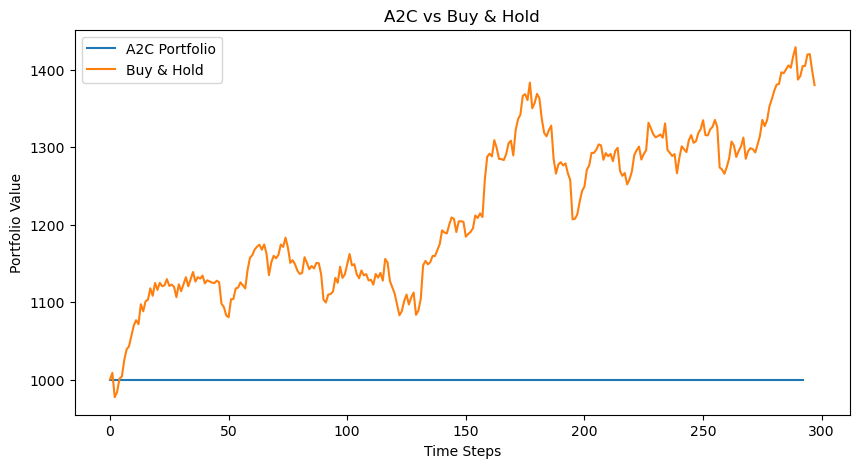

In [24]:
num_assets = len(df['Ticker'].unique())
feature_list = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'MA_10', 'MA_50', 'MA_200']

train_env = DummyVecEnv([lambda: Mult_asset_env(df=df_train,
                                          num_assets=num_assets,
                                          features_list=feature_list,
                                          window_size=5)])

print ('\n ---Initializing A2C Model and Starting Training ---')
model_A2C = A2C('MlpPolicy', train_env, verbose=1)

model_A2C.learn(total_timesteps=500000)

print ('\n --- A2C Model Training Finished ---')
print ('You can now evaluate the trained model_A2C or save it for later use.')

test_env = DummyVecEnv([lambda: Mult_asset_env(df=df_test,
                                          num_assets=num_assets,
                                          features_list=feature_list,
                                          window_size=5)])

obs = test_env.reset()
portfolio_values = []
for _ in range(len(df_test) - 5):
    action, _states = model_A2C.predict(obs, deterministic=True)
    print(action)
    obs, rewards, dones, info = test_env.step(action)
    portfolio_values.append(test_env.envs[0].balance)
    if dones:
        break

initial_cash = 1000
tickers = df['Ticker'].unique()

first_prices = []
last_prices = []
for ticker in tickers:
    df_ticker = df_test[df_test['Ticker'] == ticker]
    first_prices.append(df_ticker['Close'].iloc[0])
    last_prices.append(df_ticker['Close'].iloc[-1])

shares_per_asset = (initial_cash / len(tickers)) / np.array(first_prices)
bh_values = []
test_dates = df_test.index.unique()
for i in range(len(test_dates)):
    current_date = test_dates[i]
    total_value = 0
    for j, ticker in enumerate(tickers):
        price = df_test[(df_test.index == current_date) & (df_test['Ticker'] == ticker)]['Close'].iloc[0]
        total_value += shares_per_asset[j] * price
    bh_values.append(total_value)
    
    
plt.figure(figsize=(10, 5))
plt.plot(portfolio_values, label = "A2C Portfolio")
plt.plot(bh_values, label='Buy & Hold')
plt.xlabel('Time Steps')
plt.ylabel('Portfolio Value')
plt.title('A2C vs Buy & Hold')
plt.legend()
plt.show()